In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np

In [2]:
preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)

n_pixels

{0: 225600,
 1: 227686,
 2: 228187,
 3: 227726,
 4: 227362,
 5: 225092,
 6: 227826,
 7: 227327,
 8: 227309,
 9: 227259,
 10: 227701,
 11: 224944,
 12: 227738,
 13: 226542}

In [3]:
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

pixel_ref

{0: (0, 225600),
 1: (225600, 453286),
 2: (453286, 681473),
 3: (681473, 909199),
 4: (909199, 1136561),
 5: (1136561, 1361653),
 6: (1361653, 1589479),
 7: (1589479, 1816806),
 8: (1816806, 2044115),
 9: (2044115, 2271374),
 10: (2271374, 2499075),
 11: (2499075, 2724019),
 12: (2724019, 2951757),
 13: (2951757, 3178299)}

In [4]:
cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [5]:
PARAMETERS.LBP_METHOD = 'riu2'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 1
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = False
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

df_train = pd.DataFrame()
df_test = pd.DataFrame()
for r in range(2, 5):
    db_path = f'../DB/extra_features/radius/{r}'
    for filename in Path(db_path).glob('train_train_*'):   
        file_extension = \
            str(filename).replace('train_train_', '').split('/')[-1].replace('.pkl', '')
        properties = file_extension.replace(
            'get_pyramid_dataset', 'get-pyramid-dataset').replace(
            'get_datasets_by_scale', 'get-dataset-by-scale').split('_')
        lbp_method = properties[0]
        df_train_temp = pd.read_pickle(filename, compression='gzip')
        df_test_temp = pd.read_pickle(str(filename).replace('train_train', 'train_test'), compression='gzip')
        df_train_temp = df_train_temp.drop(['Original', 'label'], axis=1)
        df_test_temp = df_test_temp.drop(['Original', 'label'], axis=1)
        df_train_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_test_temp.columns = [f'1:1_{lbp_method}_{r}']
        df_train = pd.concat([df_train, df_train_temp], axis=1)
        df_test = pd.concat([df_test, df_test_temp], axis=1)

PARAMETERS.LBP_METHOD = 'default'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False

def get_convolution_features(seed=0):
    np.random.seed(seed)
    kernel_list = [np.round(np.random.uniform(low=-1, high=1, size=(9,)).reshape(3, 3), 3) for _ in range(5)]
    kernel_list += [np.round(np.random.uniform(low=-1, high=1, size=(25,)).reshape(5, 5), 3) for _ in range(5)]

    paths = []
    for kernel in kernel_list:
        PARAMETERS.CONVOLUTION = kernel
        PARAMETERS.CONV_PATH = PARAMETERS.update_convolution_path(PARAMETERS)
        paths.append(f"../DB/extra_features/convolution/{PARAMETERS.CONV_PATH}")


    for i, path in enumerate(paths):
        train_path = list(Path(path).glob('train_train*'))[0]
        test_path = list(Path(path).glob('train_test*'))[0]
        if i == 0:
            df_train_convolutions = pd.read_pickle(train_path, compression='gzip')
            df_train_convolutions.drop(['label'], axis=1, inplace=True)
            df_train_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_train_convolutions.columns]
            df_test_convolutions = pd.read_pickle(test_path, compression='gzip')
            df_test_convolutions.drop(['label'], axis=1, inplace=True)
            df_test_convolutions.columns = [col + '_' + path.split('/')[-1] for col in df_test_convolutions.columns]
        else:
            df_temp = pd.read_pickle(train_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_train_convolutions = pd.concat([df_train_convolutions, df_temp], axis=1)
            df_temp = pd.read_pickle(test_path, compression='gzip')
            df_temp.drop(['label'], axis=1, inplace=True)
            df_temp.columns = [col + '_' + path.split('/')[-1] for col in df_temp.columns]
            df_test_convolutions = pd.concat([df_test_convolutions, df_temp], axis=1)
    return df_train_convolutions, df_test_convolutions

df_train_convolutions, df_test_convolutions = get_convolution_features(seed=0)

df_train_extra_features = pd.concat([df_train, df_train_convolutions], axis=1)
df_test_extra_features = pd.concat([df_test, df_test_convolutions], axis=1)

In [6]:
from main import load_datasets_for_lbp_operator, get_channel_features

parent_path = '../'
for i, lbp_operator in enumerate(['default', 'riu', 'riu2', 'nriuniform', 'var']):
    PARAMETERS.LBP_METHOD = lbp_operator
    PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
    if i == 0:
        df_train, df_test, y_train, y_test = load_datasets_for_lbp_operator(parent_path)
    else:
        temp_datasets = load_datasets_for_lbp_operator(parent_path, discard_columns=True)
        df_train = pd.concat([df_train, temp_datasets[0]], axis=1)
        df_test = pd.concat([df_test, temp_datasets[1]], axis=1)
        
df_train_channels, df_test_channels = get_channel_features(parent_path)
df_train = pd.concat([df_train, df_train_channels], axis=1)
df_test = pd.concat([df_test, df_test_channels], axis=1)

In [7]:
df_train = pd.concat([df_train, df_train_extra_features], axis=1)
df_test = pd.concat([df_test, df_test_extra_features], axis=1)

In [8]:
df_train

,Original,default_1:1,default_1:2,default_1:4,default_1:8,default_2:1_1,default_2:1_2,default_2:1_3,default_2:1_4,riu_1:1,...,2:1_4_0.451;0.003;0.912;0.288;-0.152;0.213;-0.962;-0.397;0.32;-0.42;0.236;-0.142;-0.729;-0.403;0.14;0.182;0.149;0.306;0.304;-0.137;0.793;-0.265;-0.128;0.784;0.612,Original_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:1_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:2_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:4_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,1:8_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_1_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_2_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_3_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657,2:1_4_0.408;-0.8;0.839;0.428;0.998;-0.701;0.736;-0.675;0.231;-0.752;0.696;0.615;0.138;-0.186;-0.862;0.395;-0.093;0.444;0.733;0.951;0.712;-0.977;-0.28;0.46;-0.657
0,1,225,225,225,225,193,192,227,225,8,...,255,1,1,31,17,17,239,231,1,1
1,1,225,225,225,225,240,241,224,241,8,...,239,2,1,31,17,17,225,225,1,0
2,1,225,225,225,225,225,241,225,225,8,...,239,3,1,31,17,17,160,241,21,1
3,1,225,225,225,225,225,241,225,225,8,...,225,3,1,31,17,17,225,225,1,1
4,1,225,225,225,225,224,241,225,224,8,...,225,3,1,31,17,17,241,224,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226537,1,30,14,31,30,30,30,30,30,8,...,1,5,16,16,13,1,255,254,1,0
226538,1,30,14,31,30,30,31,31,31,8,...,0,5,17,16,13,1,255,0,16,22
226539,1,30,30,31,30,30,30,30,30,8,...,16,5,1,255,0,1,16,16,30,30
226540,1,30,30,31,30,30,30,30,30,8,...,17,5,0,255,0,1,16,16,30,30


In [9]:
from main import init_clf_and_fit

y_train = y_train.to_frame()
for k, v in cv_folds.items():
    PARAMETERS.MODEL_NAME = f"_cv_{k}"
    df_train_temp = pd.concat([df_train.iloc[cv_folds[0][0]:v[0], :], df_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    y_train_temp = pd.concat([y_train.iloc[cv_folds[0][0]:v[0], :], y_train.iloc[v[1]:cv_folds[4][1], :]], axis=0)
    clf = init_clf_and_fit(df_train_temp, y_train_temp, lgb='Num', parent_path='../models')
    y_predicted = clf.predict(df_train.iloc[v[0]:v[1], :])

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.600519 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.765643 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.350458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.586722 seconds.
You can set `force_col_wise=true` to remove the overhead.


/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.522654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


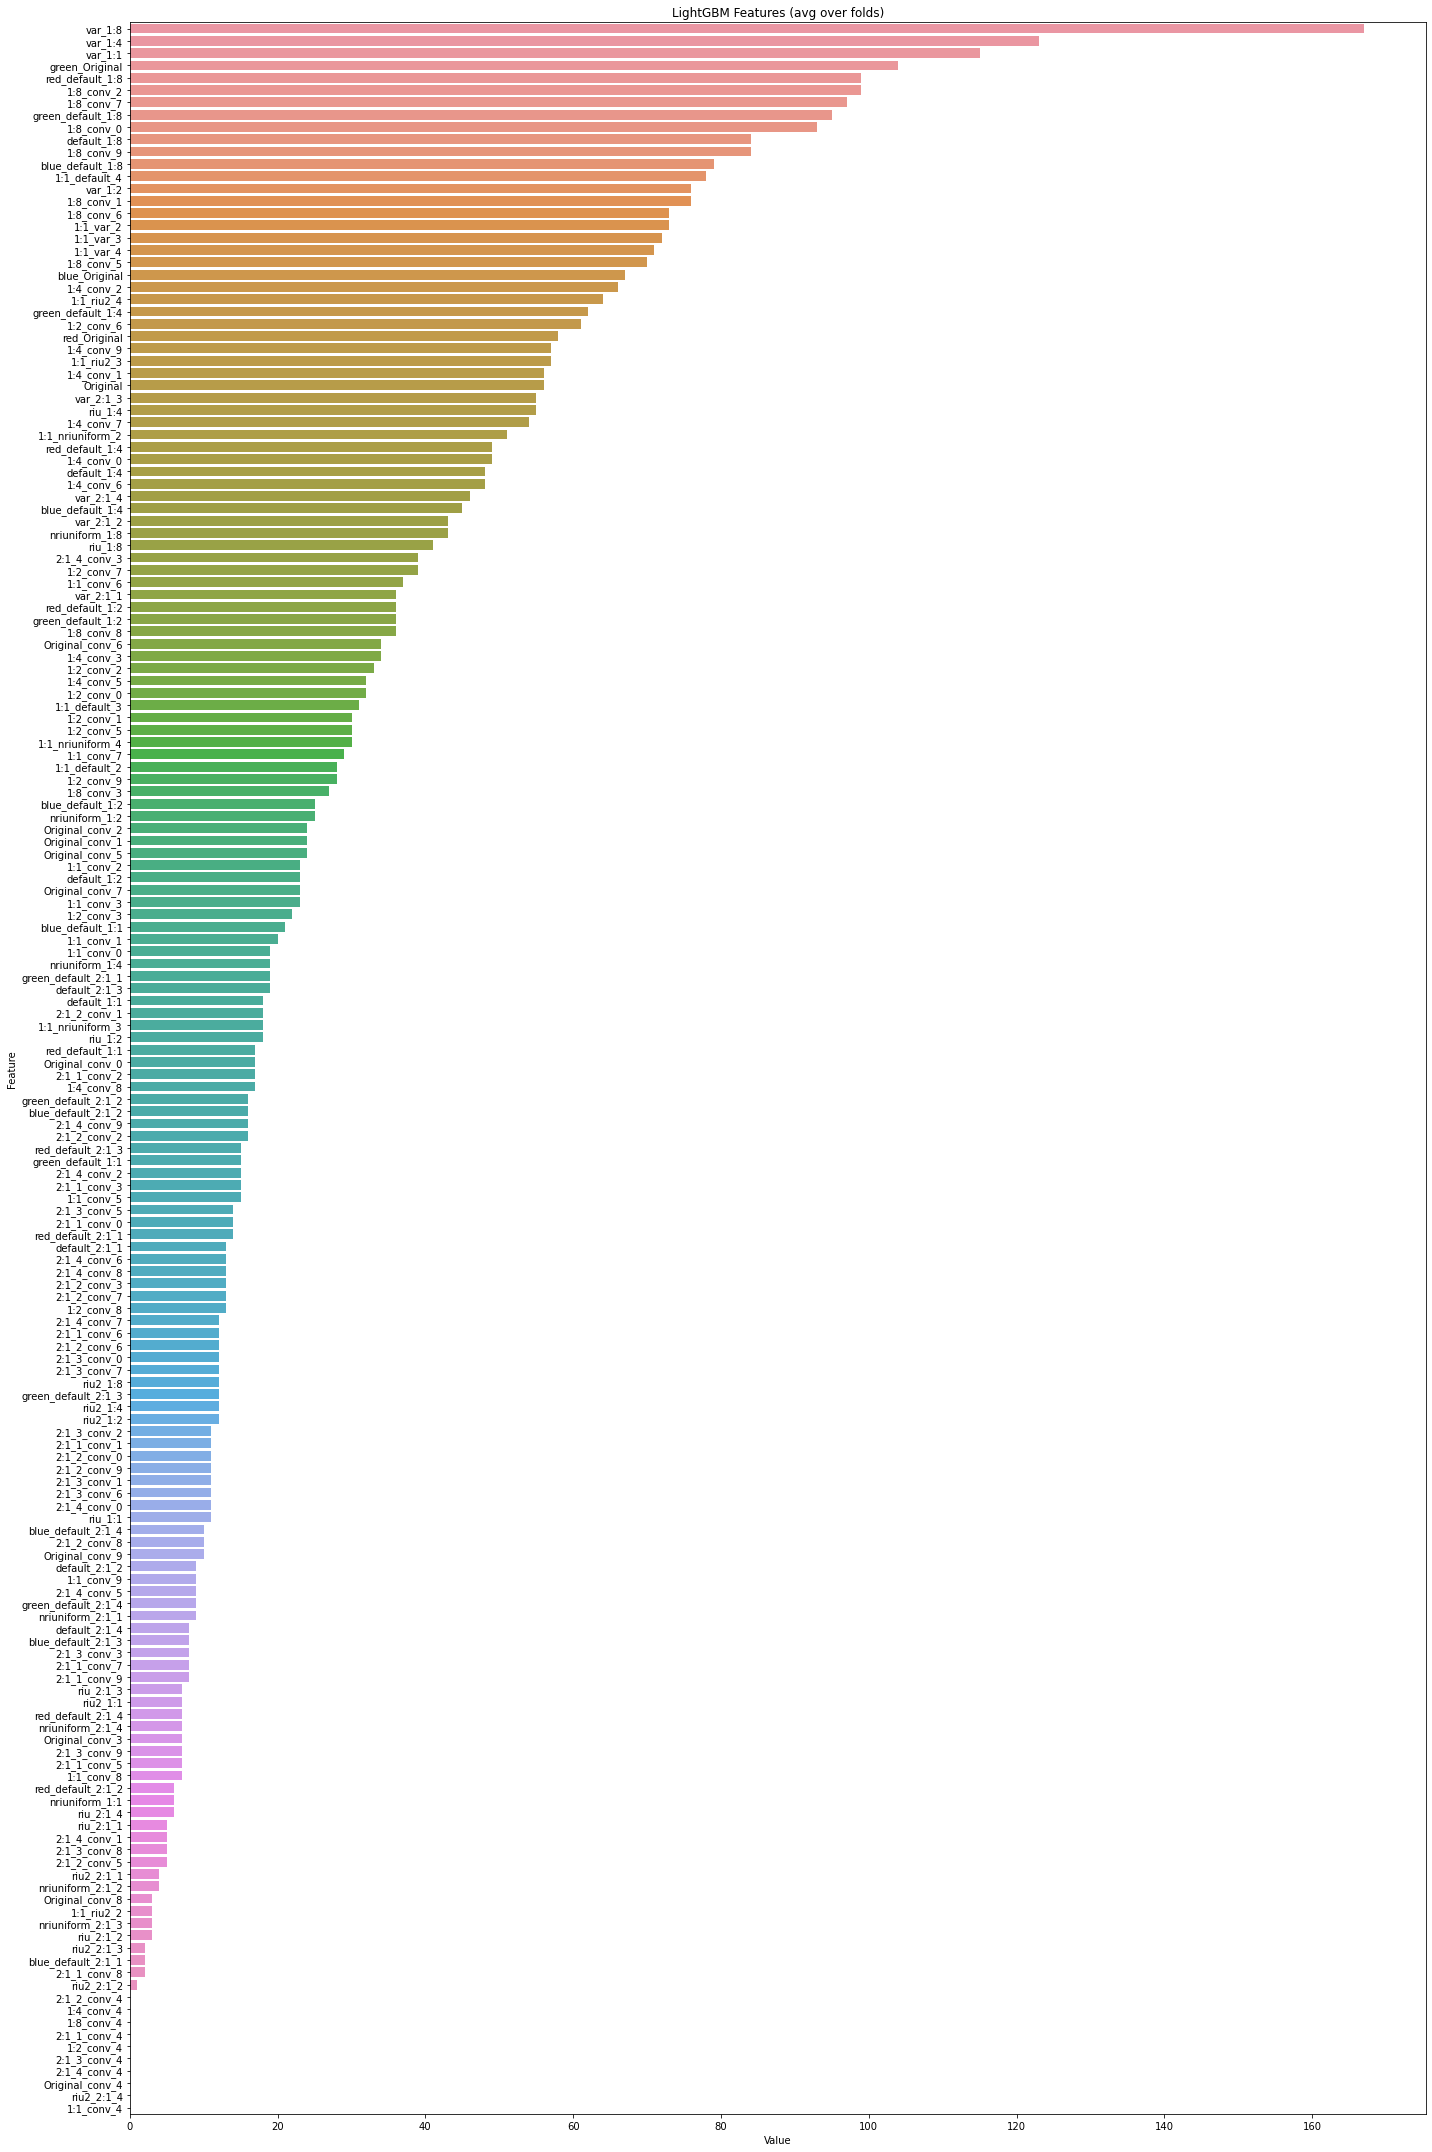

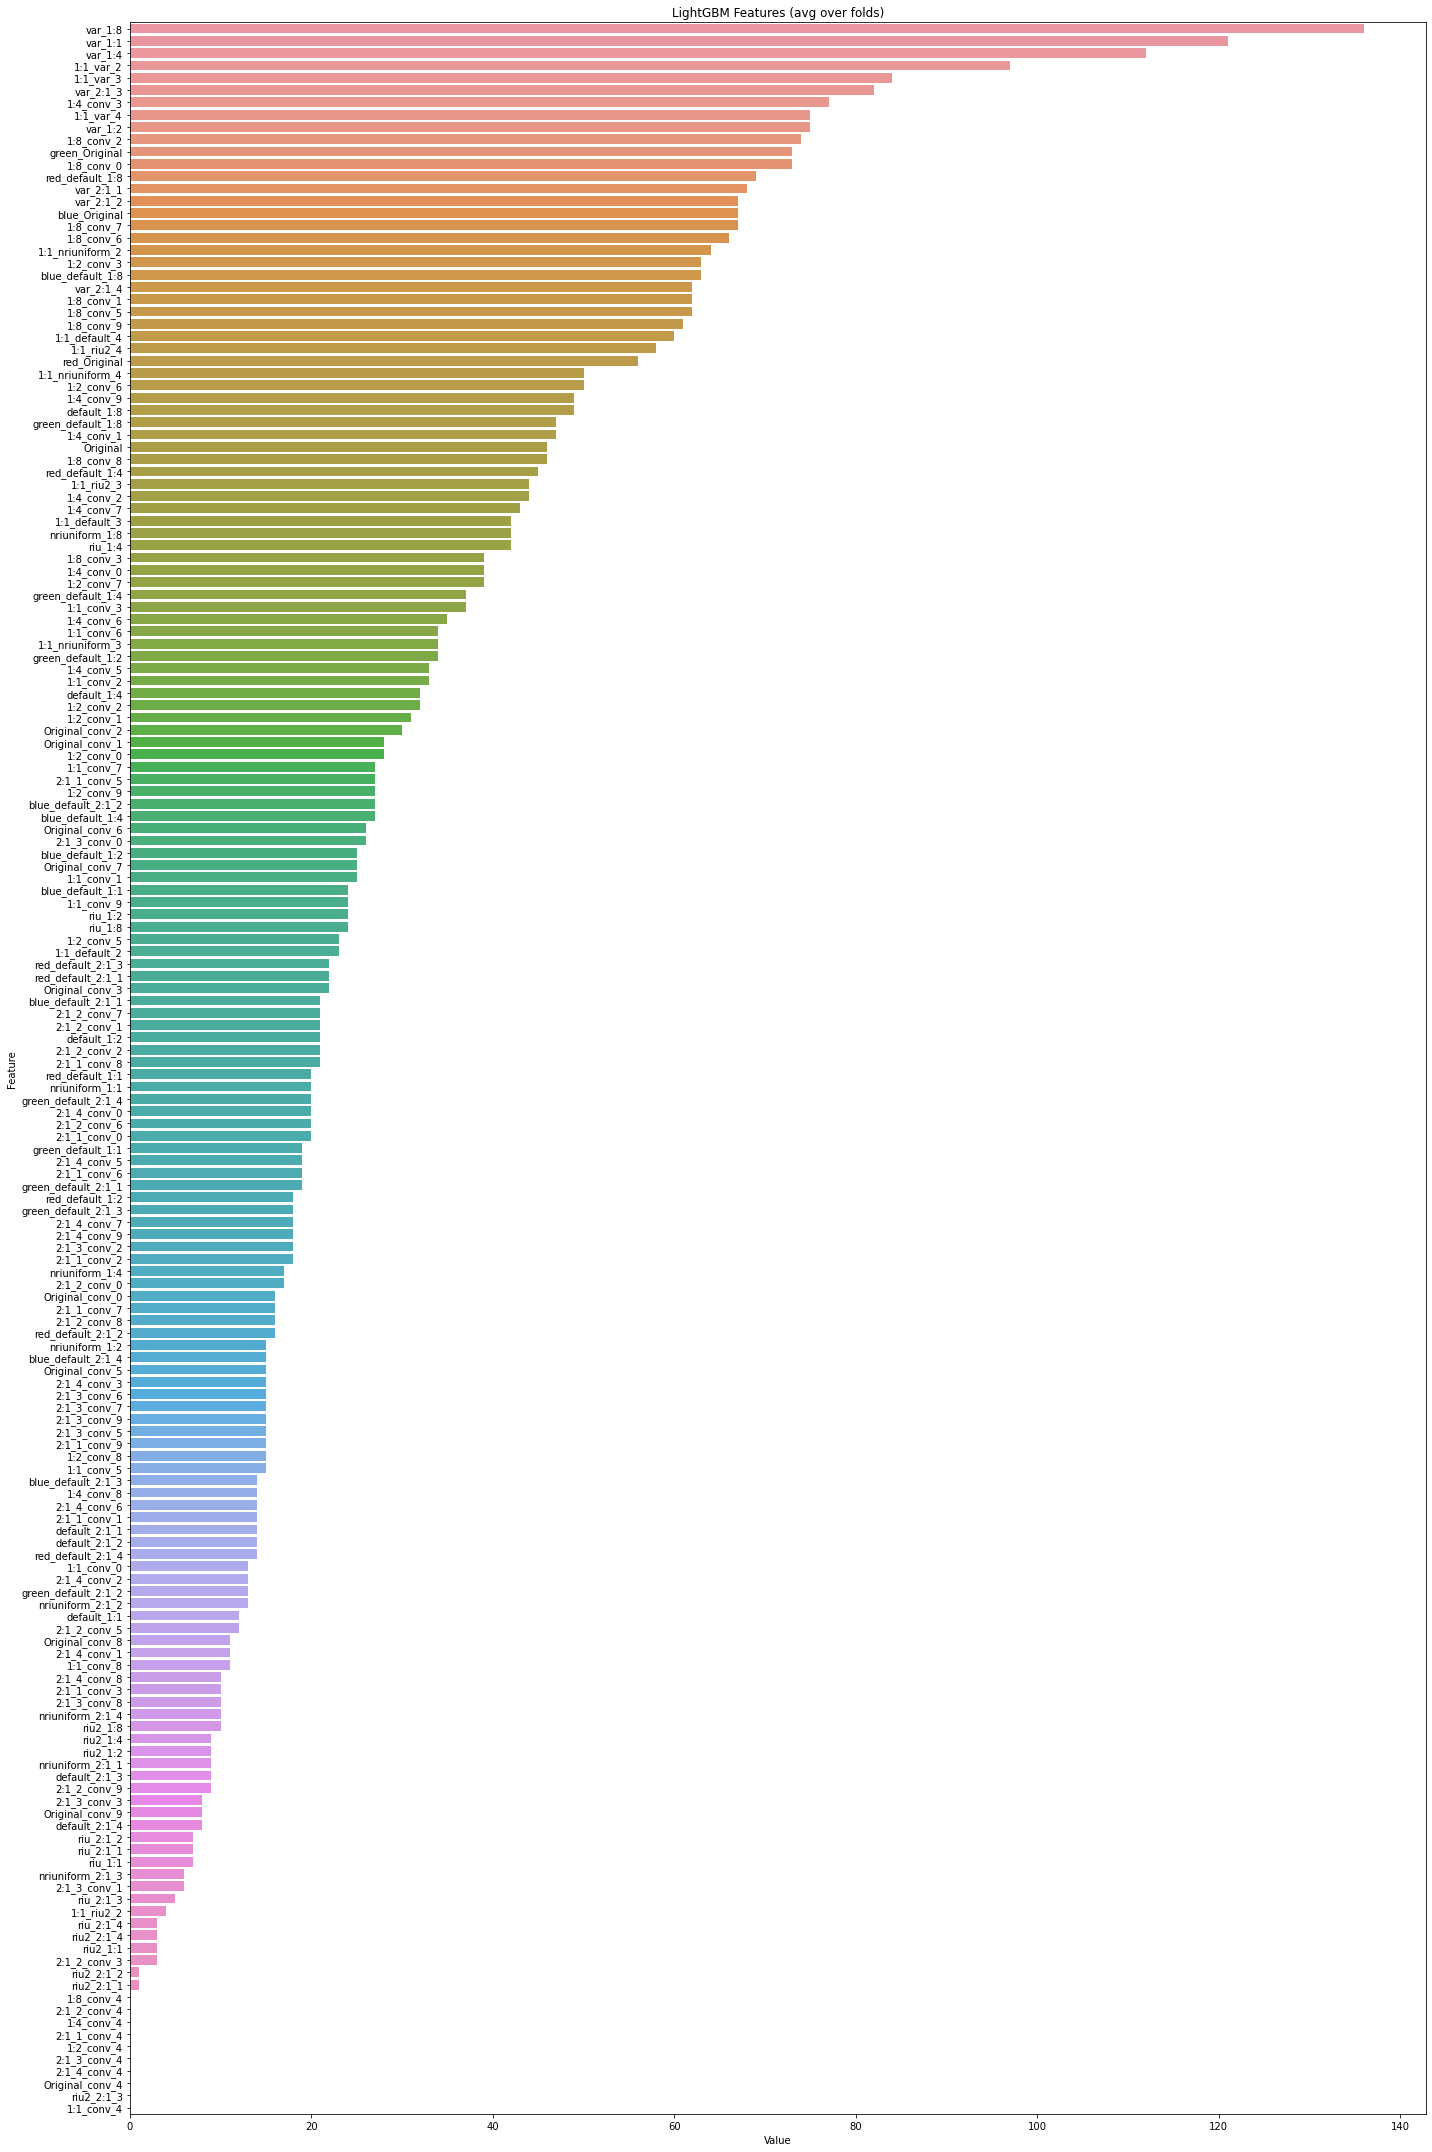

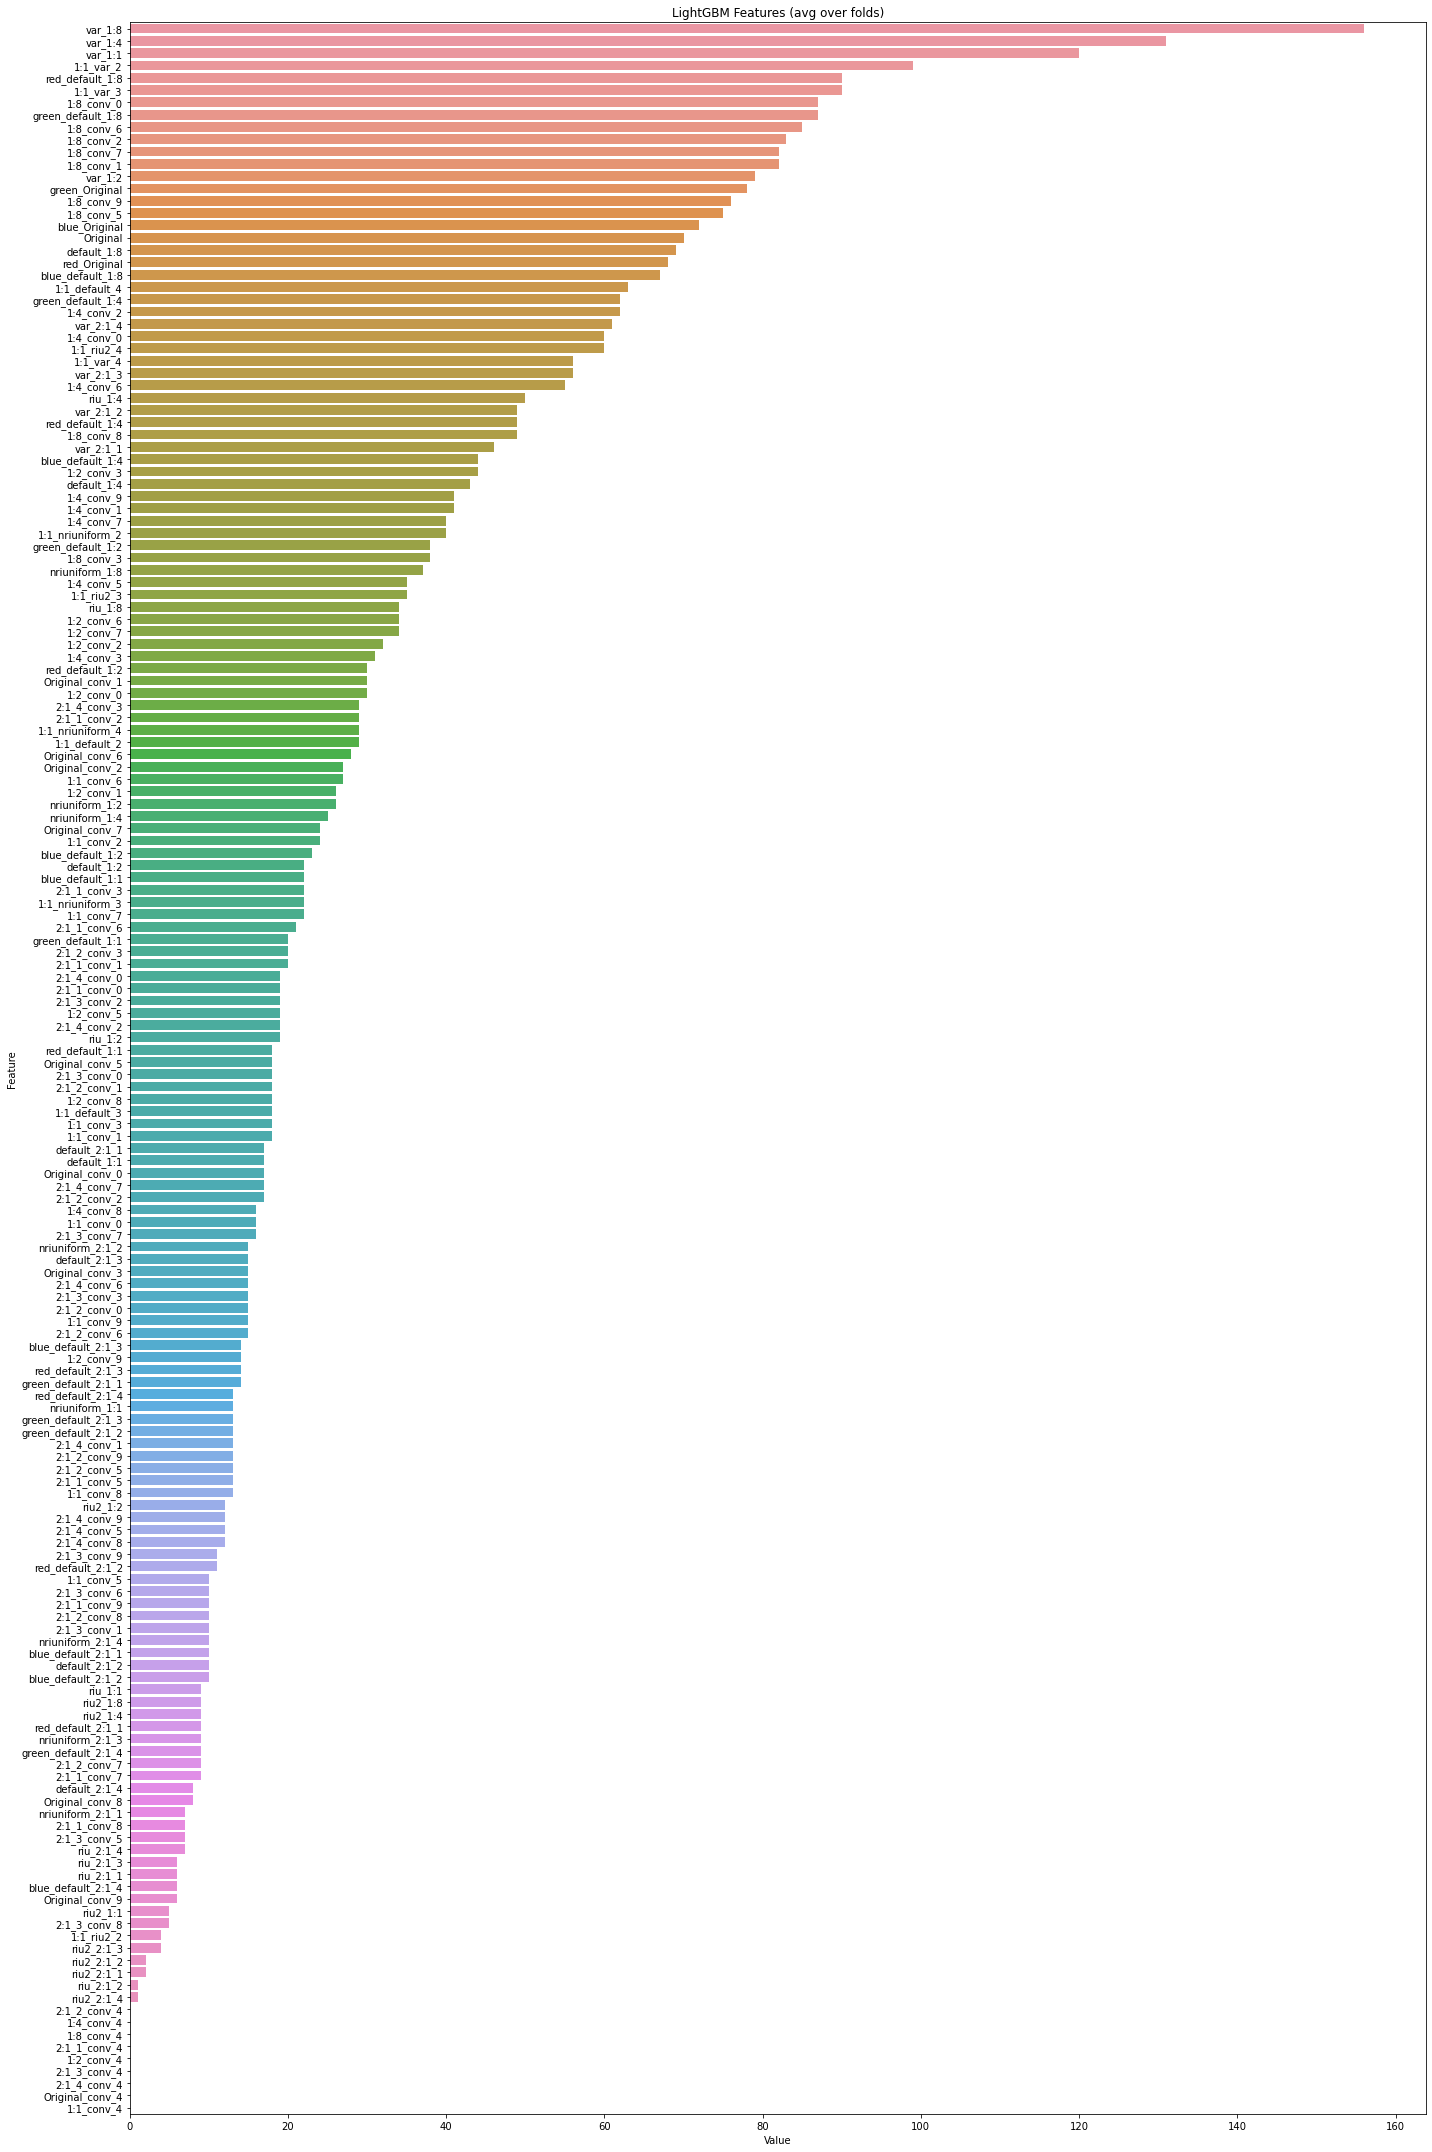

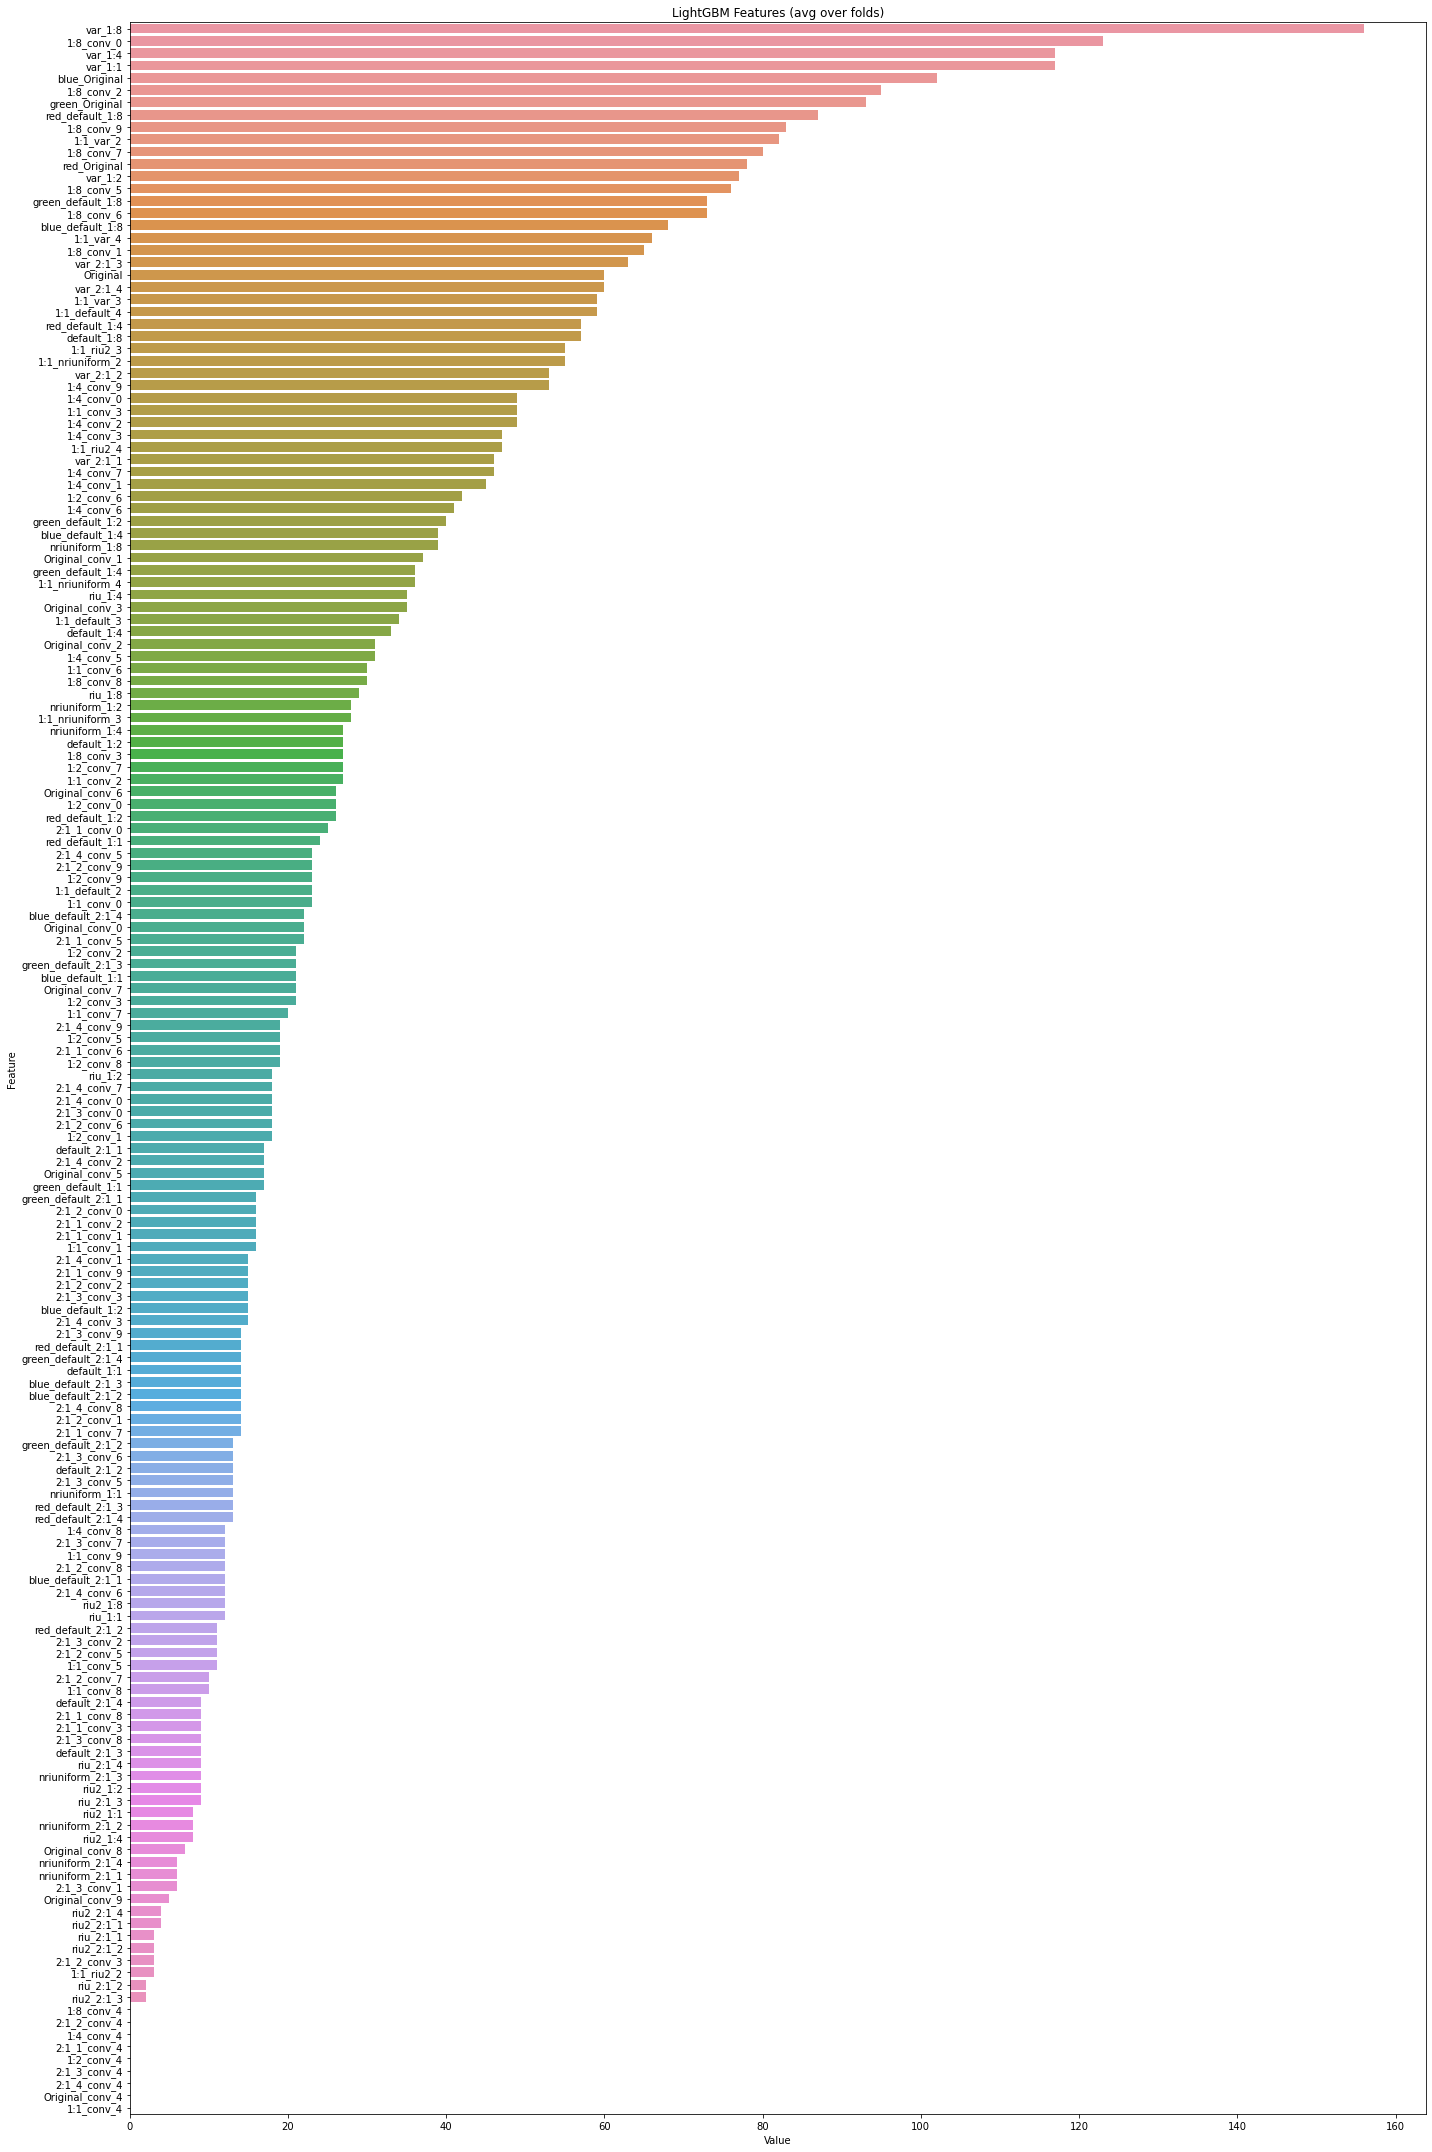

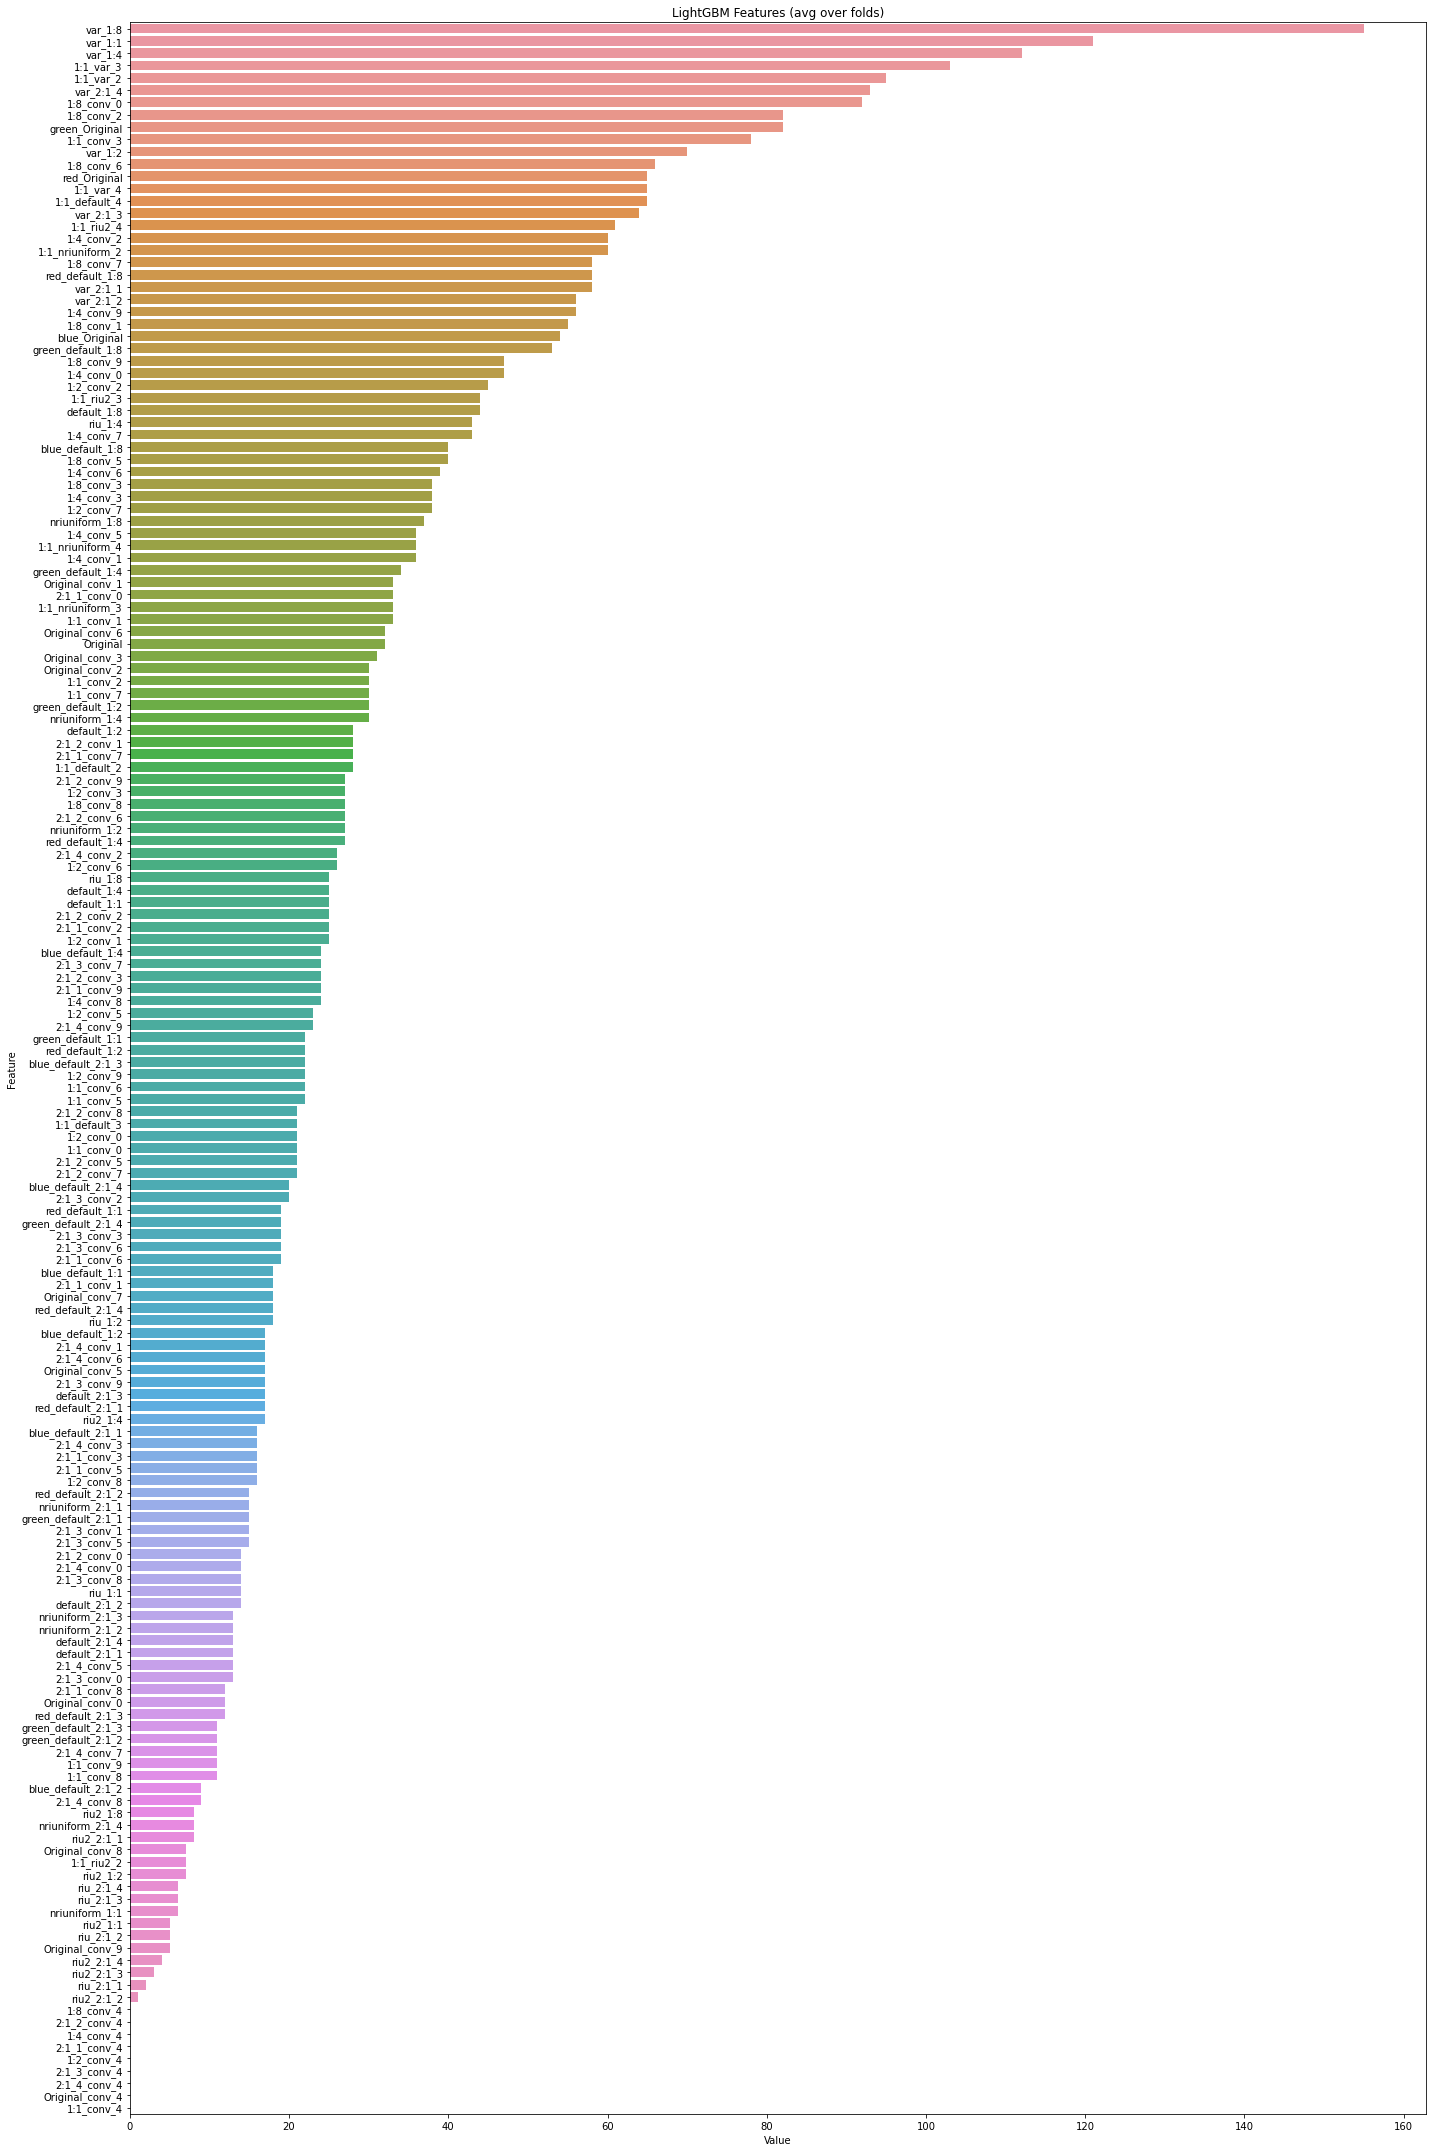

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = {}
for i in range(5):
    with open(f"../models/lbm_fit_cv_{i}.pkl", 'rb') as f:
        model = pickle.load(f)
    feature_imp[i] = pd.DataFrame(sorted(zip(model['clf'].feature_importances_, model['features'])), columns=['Value','Feature'])
    convolutions = list(set([c.split('_')[-1] for c in feature_imp[i]['Feature'] if ';' in c]))
    convolutions = {c: f'conv_{i}' for i, c in enumerate(convolutions)}
    feature_imp[i]['Feature'] = [c if ';' not in c else c.replace(c.split('_')[-1], convolutions[c.split('_')[-1]]) for c in feature_imp[i]['Feature']]


    plt.figure(figsize=(20, 30))
    sns.barplot(x="Value", y="Feature", data=feature_imp[i].sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [21]:
df_feature_imp = feature_imp[0].sort_values(by="Feature")
for i, df in enumerate(feature_imp.values()):
    if i > 0:
        df_feature_imp['Value'] += df.sort_values(by="Feature")["Value"]

In [24]:
df_feature_imp = df_feature_imp.sort_values(by="Value", ascending=False)
df_feature_imp

,Value,Feature
169,770,var_1:8
168,619,var_1:4
167,576,var_1:1
166,520,green_Original
165,470,red_default_1:8
...,...,...
4,0,2:1_1_conv_4
5,0,2:1_2_conv_4
6,0,2:1_3_conv_4
8,0,Original_conv_4


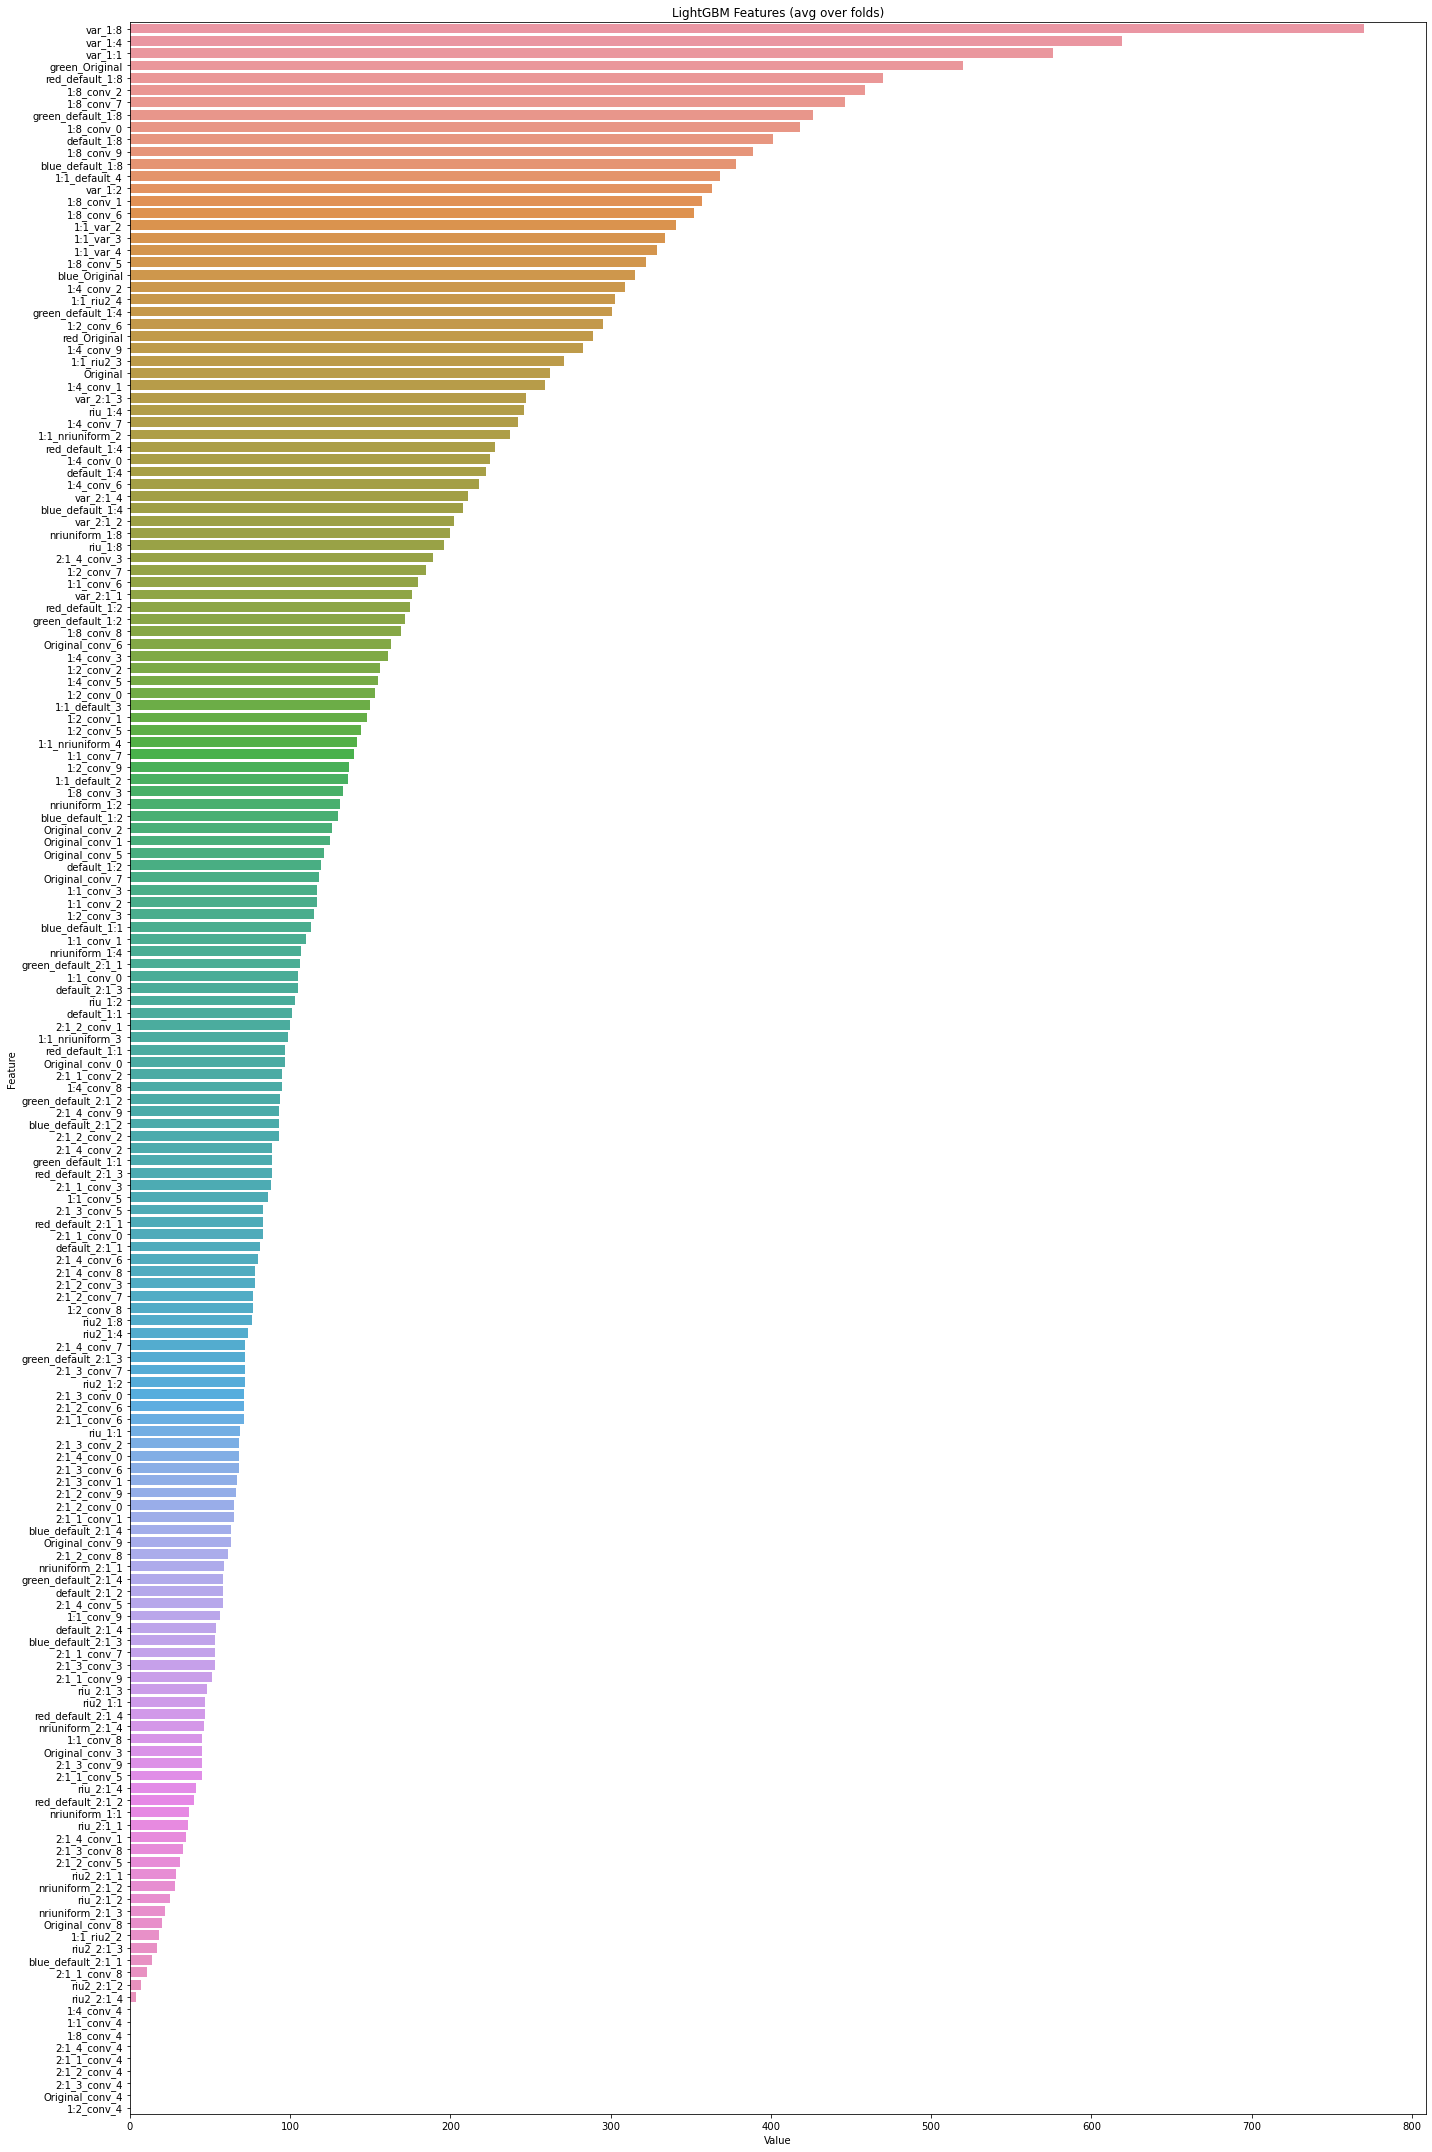

In [25]:
plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=df_feature_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
np.unique(df_train['var_1:8'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [34]:
from confusion_matrix_pretty_print import print_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def train_predict_metrics(x_train, x_test, y_train, y_test):
    clf = init_clf_and_fit(x_train, y_train, 'Num', parent_path + '/models')
    y_predicted = clf.predict(x_test)

    label_predicted = np.array(y_predicted)
    preprocess = Preprocess(height=608, width=576)
    images_path = f'{parent_path}/dataset/training/images/'
    image_path = sorted(os.listdir(images_path))[14]
    masks_path = f'{parent_path}/dataset/training/mask/'
    mask_path = sorted(os.listdir(masks_path))[14]
    img = preprocess.read_img(images_path + image_path).ravel()
    mask = preprocess.read_img(masks_path + mask_path)
    img = img[mask.ravel() > 100]
    preprocess.plot_preprocess_with_label(img, label_predicted[:len(img)], mask)
    label_predicted = np.delete(label_predicted, np.arange(len(img)))
    
    acc = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted)
    mat = confusion_matrix(y_test, y_predicted).ravel()
    print('Accuracy score: ' + str(acc) + '\n')
    print('F1 score: ' + str(f1) + '\n')
    print('Confusion matrix:\n')
    print_confusion_matrix(y_test, y_predicted)
    print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
    print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.350132 seconds.
You can set `force_col_wise=true` to remove the overhead.


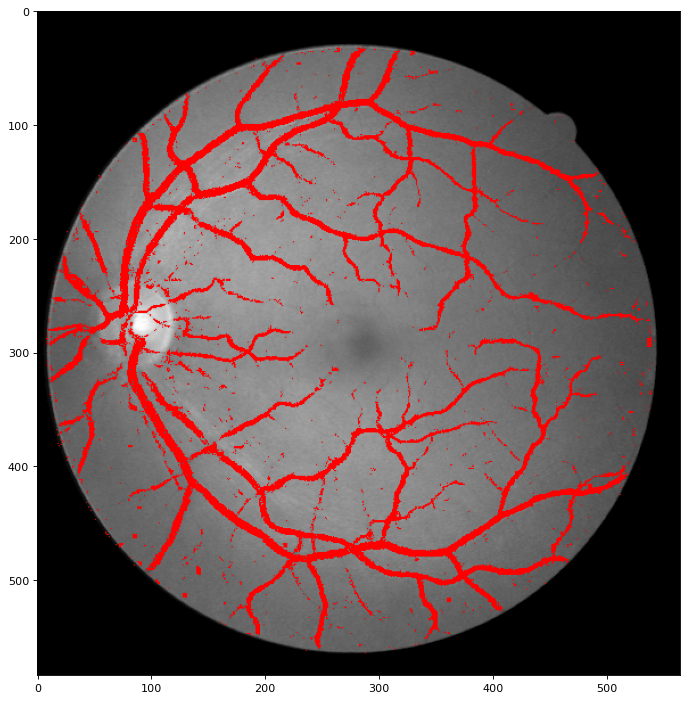

Accuracy score: 0.9348612724525521

F1 score: 0.7418233643092943

Confusion matrix:

     t/p      0     1 
        0 1146417 41128 
        1 47637 127525 
Sensivity: 0.7280403283817266
Specificity: 0.9653672071374138


In [35]:
train_predict_metrics(df_train, df_test, y_train, y_test)

In [81]:
conv_4 = list(convolutions.keys())[4]
conv_5 =  list(convolutions.keys())[5]
conv_8 =  list(convolutions.keys())[8]
conv_1 =  list(convolutions.keys())[1]
conv_6 =  list(convolutions.keys())[6]
# Remove conv_1, conv_4, conv5, conv_8, riu2, conv_6, riu2
cols_to_remove = [c for c in df_train.columns if conv_6 in c or conv_1 in c or conv_4 in c or conv_5 in c or 'riu2' in c or conv_8 in c]

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.446537 seconds.
You can set `force_col_wise=true` to remove the overhead.


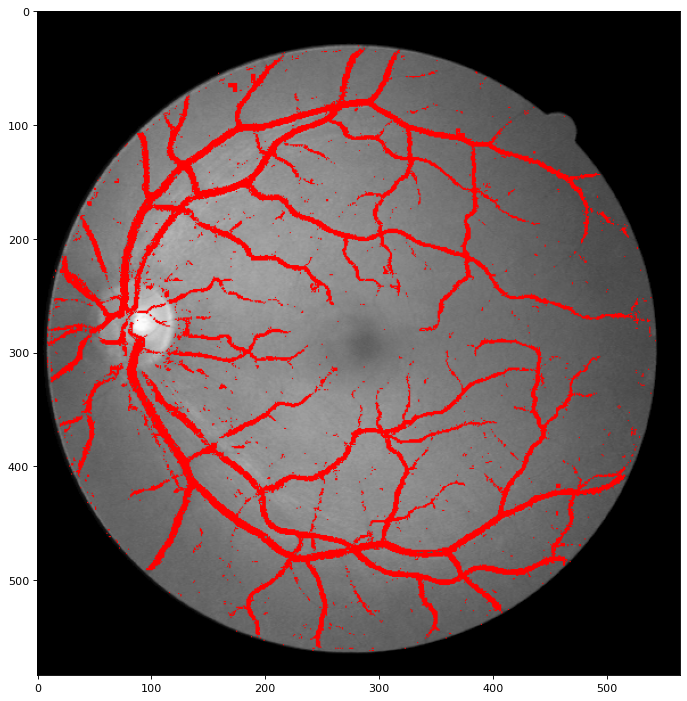

Accuracy score: 0.9344987587206934

F1 score: 0.7402414855815821

Confusion matrix:

     t/p      0     1 
        0 1146266 41279 
        1 47980 127182 
Sensivity: 0.7260821411036641
Specificity: 0.9652400540611092


In [82]:
train_predict_metrics(df_train.drop(columns=cols_to_remove), df_test.drop(columns=cols_to_remove), y_train, y_test)

In [83]:
len(cols_to_remove)

56

In [75]:
len(df_train.columns)

170